<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Obtain:-Load-Data" data-toc-modified-id="Obtain:-Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Obtain: Load Data</a></span></li><li><span><a href="#Scrub-and-Explore:" data-toc-modified-id="Scrub-and-Explore:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scrub and Explore:</a></span><ul class="toc-item"><li><span><a href="#Analysis-of-Classification-Labels" data-toc-modified-id="Analysis-of-Classification-Labels-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Analysis of Classification Labels</a></span></li><li><span><a href="#Rescale-and-Reshape-data" data-toc-modified-id="Rescale-and-Reshape-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Rescale and Reshape data</a></span></li></ul></li><li><span><a href="#Functions:" data-toc-modified-id="Functions:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Functions:</a></span></li><li><span><a href="#Models:" data-toc-modified-id="Models:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Models:</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#MLP-with-Dropout" data-toc-modified-id="MLP-with-Dropout-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>MLP with Dropout</a></span></li><li><span><a href="#CNN" data-toc-modified-id="CNN-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>CNN</a></span><ul class="toc-item"><li><span><a href="#TensorBoard" data-toc-modified-id="TensorBoard-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>TensorBoard</a></span></li></ul></li><li><span><a href="#CNN-with-Augmentation" data-toc-modified-id="CNN-with-Augmentation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>CNN with Augmentation</a></span></li><li><span><a href="#CNN-with-Dropout-and-Class-Weights" data-toc-modified-id="CNN-with-Dropout-and-Class-Weights-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>CNN with Dropout and Class Weights</a></span></li><li><span><a href="#L2-Regularization" data-toc-modified-id="L2-Regularization-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>L2 Regularization</a></span></li><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Transfer Learning</a></span></li></ul></li><li><span><a href="#Results:" data-toc-modified-id="Results:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results:</a></span></li></ul></div>

# Detecting Pneumonia 
--- 
Image classification with Machine Learning

By: Cassie Nutter

## Load Libraries

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import array_to_img, img_to_array
import datetime
from keras import layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras import regularizers
import os, shutil

%load_ext tensorboard
# rm -rf ./logs/ # clear logs from previous runs


from sklearn.metrics import classification_report, confusion_matrix, \
plot_confusion_matrix

np.random.seed(100)
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from scipy import ndimage
from keras.models import load_model

## Obtain: Load Data
--- 
Data used for this analysis comes from Kaggle. You can find the data [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

In [2]:
# set directory paths
data_test_dir = '../data_chest_xray/test/'
data_train_dir = '../data_chest_xray/train/'
data_val_dir = '../data_chest_xray/val/'
main_dir = 'split/'

In [3]:
# create new directory
os.mkdir(main_dir)

In [4]:
#create folders and subfolders to put in new directory

train_folder = os.path.join(main_dir, 'train')
#train folder data
train_pneum = os.path.join(train_folder, 'PNEUMONIA/')
train_norm = os.path.join(train_folder, 'NORMAL/')

test_folder = os.path.join(main_dir, 'test/')
#test folder data
test_pneum = os.path.join(test_folder, 'PNEUMONIA/')
test_norm = os.path.join(test_folder, 'NORMAL/')

val_folder = os.path.join(main_dir, 'val/')
#validation folder data
val_pneum = os.path.join(val_folder, 'PNEUMONIA/')
val_norm = os.path.join(val_folder, 'NORMAL/')

An 80 / 10 / 10 split would be best. Right now, there isn't enough data to accurately validate our models. So let's move 10% of data from the training set to the validation set.

In [5]:
# check the path
train_norm

'split/train/NORMAL/'

In [6]:
# add the folders to the directory
folders = [train_folder, train_pneum, train_norm, test_folder, test_pneum, 
           test_norm, val_folder, val_pneum, val_norm]

make_dirs = [os.mkdir(folder) for folder in folders]

In [7]:
# function to move images from original dataset to new dataset
def copy_images(directory, label, dest):
    imgs = [file for file in os.listdir(directory + label) if file.endswith('.jpeg')]
    for img in imgs:
        origin = os.path.join(directory + label, img)
        destination = os.path.join(dest, img)
        shutil.copyfile(origin, destination)

In [8]:
# copy images from original dataset to new folders
# train data
copy_images(data_train_dir, 'PNEUMONIA/', train_pneum)
copy_images(data_train_dir, 'NORMAL/', train_norm)

# test data
copy_images(data_test_dir, 'PNEUMONIA/', test_pneum)
copy_images(data_test_dir, 'NORMAL/', test_norm)

# validation data
copy_images(data_val_dir, 'PNEUMONIA/', val_pneum)
copy_images(data_val_dir, 'NORMAL/', val_norm)

In [9]:
# count images in each folder to verify it is the same as original
img_folders = [train_pneum, train_norm, test_pneum, test_norm, 
               val_pneum, val_norm]
folder_values = [print(f'{len(os.listdir(i))} images in folder {i}') \
          for i in img_folders]

3875 images in folder split/train/PNEUMONIA/
1341 images in folder split/train/NORMAL/
390 images in folder split/test/PNEUMONIA/
234 images in folder split/test/NORMAL/
8 images in folder split/val/PNEUMONIA/
8 images in folder split/val/NORMAL/


In [10]:
# Does this match what Kaggle says? Should have 5856 images
total = sum([len(os.listdir(i)) for i in img_folders])
total

5856

In [11]:
train_total = len(os.listdir(train_pneum)) + len(os.listdir(train_norm))
test_total = len(os.listdir(test_pneum)) + len(os.listdir(test_norm))
val_total = len(os.listdir(val_pneum)) + len(os.listdir(val_norm))

print(f'Percentage of data for training: {round(train_total / total * 100, 2)}%')
print(f'Percentage of data for testing: {round(test_total / total * 100, 2)}%')
print(f'Percentage of data for validation: {round(val_total / total * 100, 2)}%')

Percentage of data for training: 89.07%
Percentage of data for testing: 10.66%
Percentage of data for validation: 0.27%


In [12]:
# store all images
imgs_train_pneum = [file for file in os.listdir(train_pneum)]
imgs_train_norm = [file for file in os.listdir(train_norm)]

In [13]:
# Take 7% pneumonia from training data
imgs = imgs_train_pneum[:410]
for img in imgs:
    origin = os.path.join(train_pneum, img)
    destination = os.path.join(val_pneum, img)
    shutil.move(origin, destination)

# Take ~3% normal from training data
imgs2 = imgs_train_norm[:150]
for img in imgs2:
    origin = os.path.join(train_norm, img)
    destination = os.path.join(val_norm, img)
    shutil.move(origin, destination)

In [14]:
# see how it worked
train_total = len(os.listdir(train_pneum)) + len(os.listdir(train_norm))
test_total = len(os.listdir(test_pneum)) + len(os.listdir(test_norm))
val_total = len(os.listdir(val_pneum)) + len(os.listdir(val_norm))

print(f'Percentage of data for training: {round(train_total / total * 100, 2)}%')
print(f'Percentage of data for testing: {round(test_total / total * 100, 2)}%')
print(f'Percentage of data for validation: {round(val_total / total * 100, 2)}%')

Percentage of data for training: 79.51%
Percentage of data for testing: 10.66%
Percentage of data for validation: 9.84%


Not exactly 80 / 10 / 10 but very close. Let's keep going.

## Scrub and Explore:
---
Let's see what the images look like, then make sure they are in a form our models can understand.

Text(0.5, 1.0, 'PNEUMONIA')

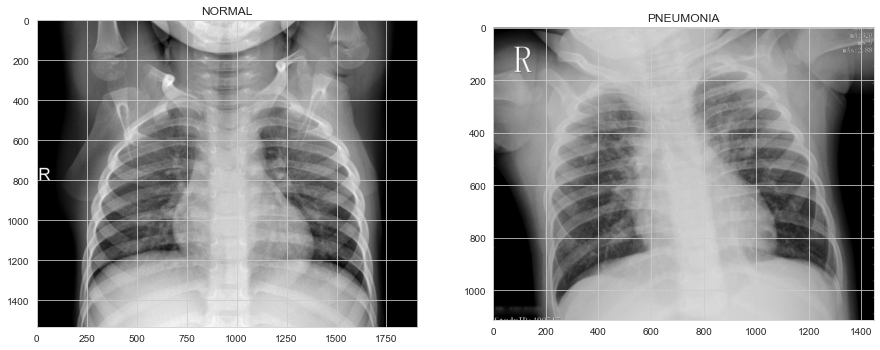

In [15]:
# Pick 2 images - one from each classification
img_name = 'NORMAL2-IM-0509-0001.jpeg'
img_normal = load_img(train_norm + img_name)

img_name2 = 'person359_virus_738.jpeg'
img_pneum = load_img(train_pneum + img_name2)

# view those images
fig = plt.figure(figsize= (15,10))
ax1 = fig.add_subplot(1,2,1)
img_plt = plt.imshow(img_normal)
ax1.set_title('NORMAL')

ax2 = fig.add_subplot(1,2,2)
img_plt = plt.imshow(img_pneum)
ax2.set_title('PNEUMONIA')

### Analysis of Classification Labels
---
Judging from what we saw already, there seems to be a class imbalance. Let's take a closer look.

In [16]:
# make a DataFrame to visualize data
train_df = []
for file in os.listdir(train_norm):
    train_df.append((file, 0))
for file in os.listdir(train_pneum):
    train_df.append((file, 1))
train_df = pd.DataFrame(train_df, columns= (['image', 'label']))

In [17]:
print(train_df.info())
train_df.head(-10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4656 entries, 0 to 4655
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4656 non-null   object
 1   label   4656 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 72.9+ KB
None


,image,label
0,NORMAL2-IM-0410-0001.jpeg,0
1,IM-0471-0001.jpeg,0
2,NORMAL2-IM-1236-0001.jpeg,0
3,IM-0647-0001.jpeg,0
4,IM-0537-0001.jpeg,0
...,...,...
4641,person1164_virus_1958.jpeg,1
4642,person1461_virus_2510.jpeg,1
4643,person23_bacteria_101.jpeg,1
4644,person344_bacteria_1585.jpeg,1


In [18]:
# even though this is only checking the image name, better to check it now
train_df.duplicated().sum()

0

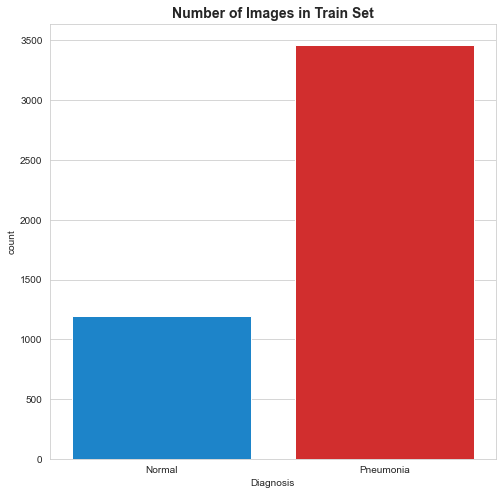

In [19]:
# visualize counts for training data
pal = ['#008ae6' , '#ec1313']
plt.figure(figsize= (8,8))
sns.countplot(x=train_df['label'], data= train_df, palette= pal)
plt.xlabel('Diagnosis')
plt.title('Number of Images in Train Set', fontsize= 14, fontweight= 'bold')
plt.xticks(range(len(train_df['label'].value_counts())), ['Normal', 'Pneumonia'])
plt.show()

In [20]:
#repeat for test and validation data
test_df = []
for file in os.listdir(test_norm):
    test_df.append((file, 0))
for file in os.listdir(test_pneum):
    test_df.append((file, 1))
test_df = pd.DataFrame(test_df, columns= (['image', 'label']))

val_df = []
for file in os.listdir(val_norm):
    val_df.append((file, 0))
for file in os.listdir(val_pneum):
    val_df.append((file, 1))
val_df = pd.DataFrame(val_df, columns= (['image', 'label']))

In [21]:
# check for duplicate image names
print(test_df.duplicated().sum())
val_df.duplicated().sum()

0


0

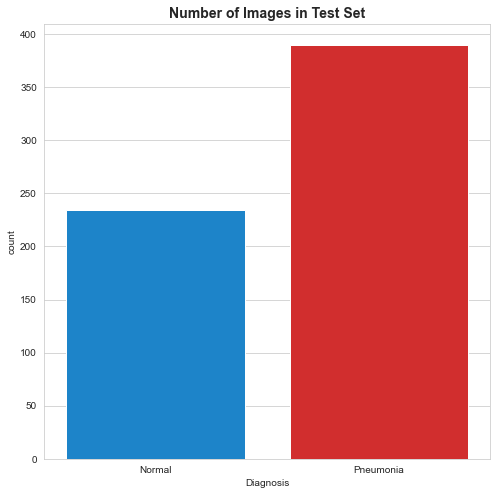

In [22]:
#plot test image counts
pal = ['#008ae6' , '#ec1313']
plt.figure(figsize= (8,8))
sns.countplot(x=test_df['label'], data= test_df, palette= pal)
plt.xlabel('Diagnosis')
plt.title('Number of Images in Test Set', fontsize= 14, fontweight= 'bold')
plt.xticks(range(len(test_df['label'].value_counts())), ['Normal', 'Pneumonia'])
plt.show()

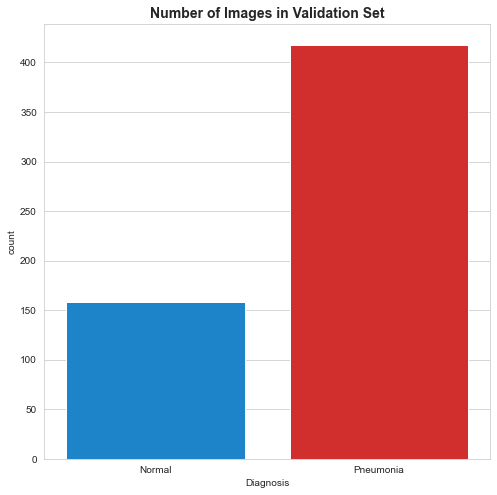

In [23]:
# visualize image counts in validation set
pal = ['#008ae6' , '#ec1313']
plt.figure(figsize= (8,8))
sns.countplot(x=val_df['label'], data= val_df, palette= pal)
plt.xlabel('Diagnosis')
plt.title('Number of Images in Validation Set', fontsize= 14, fontweight= 'bold')
plt.xticks(range(len(val_df['label'].value_counts())), ['Normal', 'Pneumonia'])
plt.show()

In [24]:
# see what % of data is in each class
print(train_df['label'].value_counts(normalize= True))
print(test_df['label'].value_counts(normalize= True))
val_df['label'].value_counts(normalize= True)

1    0.744201
0    0.255799
Name: label, dtype: float64
1    0.625
0    0.375
Name: label, dtype: float64


1    0.725694
0    0.274306
Name: label, dtype: float64

The test data has the most balanced data, though it is still far from being 50/50. Approximately one quarter of training and validation data is a "Normal" X-ray and three-quarter labeled "Pneumonia".

### Rescale and Reshape data

We will need to do some preprocessing to get the images ready to be modeled.

The most important thing we can do now is make sure all the images settings are identical.

In [25]:
# get set sizes
print('Training set size:', train_total)
print('Test set size:', test_total)
print('Validation set size:', val_total)

Training set size: 4656
Test set size: 624
Validation set size: 576


In [26]:
# ImageDataGenerator is a constructor that scales pixel values and 
# can augment versions of images
# flow_from_directory() function iterates through images in a folder

# rescale will transform the pixel values from 1-255 to 0-1
train_generator = ImageDataGenerator(rescale= 1./255).flow_from_directory(
    train_folder, 
    target_size= (150,150), 
    batch_size= 4656, 
    class_mode= 'binary')

test_generator = ImageDataGenerator(rescale= 1./255).flow_from_directory(
    test_folder, 
    target_size= (150,150), 
    batch_size= 624, 
    class_mode= 'binary')

val_generator = ImageDataGenerator(rescale= 1./255).flow_from_directory(
    val_folder, 
    target_size= (150, 150), 
    batch_size= 576, 
    class_mode= 'binary')

Found 4656 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [27]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [28]:
# create the data sets with next()
# next() returns the next item in an iterator
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [29]:
# check num of training samples and pixels for images in train data
print(train_images.shape[0])
train_images.shape[1]

4656


150

In [30]:
# show matrix shape that contains images and labels
print('Train images shape: {}'.format(train_images.shape))
print('Test images shape: {}'.format(test_images.shape))
print('Validation images shape: {}'.format(val_images.shape))
print('--------------------------------')
print('Train labels shape: {}'.format(train_labels.shape))
print('Test labels shape: {}'.format(test_labels.shape))
print('Validation labels shape: {}'.format(val_labels.shape))

Train images shape: (4656, 150, 150, 3)
Test images shape: (624, 150, 150, 3)
Validation images shape: (576, 150, 150, 3)
--------------------------------
Train labels shape: (4656,)
Test labels shape: (624,)
Validation labels shape: (576,)


In [31]:
# reshape the image matrices
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape, test_img.shape, val_img.shape)

(4656, 67500) (624, 67500) (576, 67500)


In [32]:
train_labels

array([1., 1., 0., ..., 0., 0., 1.], dtype=float32)

In [33]:
# reshape labels as well from row vector to column vector
train_y = train_labels.reshape(-1,1)
test_y = test_labels.reshape(-1,1)
val_y = val_labels.reshape(-1,1)
val_y.shape

(576, 1)

## Functions:
---
Functions that will be used to plot accuracy, loss and confusion matrices.

In [90]:
# This function will display the visualiztions of loss and accuracy
# during each epoch

def visualize_results(results):
    history = results.history
    plt.figure(figsize= (18, 5))
    plt.subplot(1,2,1)
    plt.plot(history['val_loss'], color= 'orange')
    plt.plot(history['loss'], color= 'red')
    plt.legend(['Val loss', 'Loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1,2,2)
    plt.plot(history['val_acc'], color= 'green')
    plt.plot(history['acc'], color= 'blue')
    plt.legend(['Val Accuracy', 'Accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [103]:
'''This function will display the results from each model including:
training and validation loss and accuracy, confusion matrices 
and classification reports'''
# create empty list to store results
results_list = []

def get_results(Xtrain, ytrain, Xval, yval, model, model_name, total_time):
    # evaluate results from training and validation data and display
    train_eval = model.evaluate(Xtrain, ytrain, verbose= 0)
    print('Training Data Loss:', train_eval[0])
    print('Training Data Accuracy', train_eval[1])
    print('--------------------------')
    
    val_eval = model.evaluate(Xval, yval, verbose= 0)
    print('Validation Data Loss:', val_eval[0])
    print('Validation Data Accuracy', val_eval[1], '\n')

    
    # print classification report
    y_pred = model.predict(Xval)
    y_pred = np.rint(y_pred)
    print(classification_report(yval, y_pred))
    
    # display confusion matrix
    cm = confusion_matrix(yval, y_pred)
    
    plt.figure(figsize= (9,7))
    categories = ['Normal', 'Pneumonia']
    sns.heatmap(cm, annot= True, cmap='Blues', fmt= 'g', 
                xticklabels= categories, yticklabels= categories, cbar= False, 
                linewidths= 1, linecolor='gray')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix', fontsize= 14, fontweight= 'bold')
    
    # add results to list
    results_list.append((model_name, round(train_eval[0]*100,2), round(val_eval[0]*100,2), 
                         round(train_eval[1]*100,2), round(val_eval[1]*100,2), 
                         total_time))

In [36]:
sdfisdf

NameError: name 'sdfisdf' is not defined

## Models:

### Baseline
First, a baseline model:

In [92]:
baseline = Sequential()
baseline.add(layers.Dense(64, activation= 'relu', input_shape= (67500,)))
baseline.add(layers.Dense(32, activation= 'relu'))
baseline.add(layers.Dense(16, activation= 'relu'))
baseline.add(layers.Dense(1, activation= 'sigmoid'))

baseline.compile(optimizer= 'sgd', loss= 'binary_crossentropy', metrics= ['acc'])

start = datetime.datetime.now()
history = baseline.fit(train_img, 
                    train_y, 
                    epochs= 50, 
                    batch_size= 32, #default
                    validation_data= (val_img, val_y))
end = datetime.datetime.now()
total_time = end-start

Epoch 1/50
146/146 [==============================] - 1s 9ms/step - loss: 0.5485 - acc: 0.7320 - val_loss: 0.4803 - val_acc: 0.7274
Epoch 2/50
146/146 [==============================] - 1s 9ms/step - loss: 0.3882 - acc: 0.8299 - val_loss: 0.3502 - val_acc: 0.8316
Epoch 3/50
146/146 [==============================] - 1s 9ms/step - loss: 0.2706 - acc: 0.8890 - val_loss: 0.2522 - val_acc: 0.8976
Epoch 4/50
146/146 [==============================] - 1s 9ms/step - loss: 0.2526 - acc: 0.8997 - val_loss: 0.1903 - val_acc: 0.9219
Epoch 5/50
146/146 [==============================] - 1s 8ms/step - loss: 0.2019 - acc: 0.9238 - val_loss: 0.1497 - val_acc: 0.9410
Epoch 6/50
146/146 [==============================] - 1s 9ms/step - loss: 0.1894 - acc: 0.9216 - val_loss: 0.1729 - val_acc: 0.9288
Epoch 7/50
146/146 [==============================] - 1s 9ms/step - loss: 0.1849 - acc: 0.9285 - val_loss: 0.3640 - val_acc: 0.8472
Epoch 8/50
146/146 [==============================] - 1s 9ms/step - loss: 0.

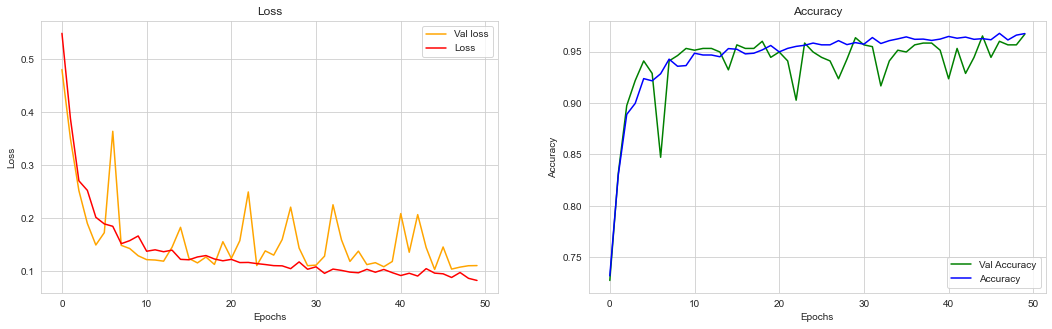

In [93]:
visualize_results(history)

In [94]:
baseline.metrics_names

['loss', 'acc']

Training Data Loss: 0.07116826623678207
Training Data Accuracy 0.9718642830848694
--------------------------
Validation Data Loss: 0.1108270063996315
Validation Data Accuracy 0.9670138955116272 

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94       158
         1.0       0.96      1.00      0.98       418

    accuracy                           0.97       576
   macro avg       0.97      0.94      0.96       576
weighted avg       0.97      0.97      0.97       576



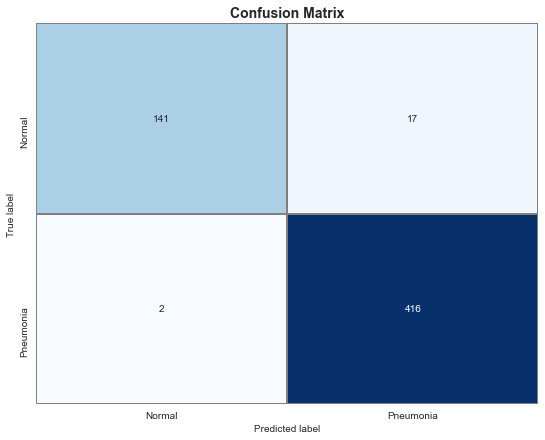

In [104]:
get_results(train_img, train_y, val_img, val_y, baseline, 'baseline', 
            total_time)

Wow. Not too bad for our baseline. 

### MLP with Dropout
Now we can begin really building up some layers, tuning hyperparameters, and using data augmentation.

In [ ]:
#build a model with 4 hidden layers and dropout layers
dropout_MLP = Sequential()
dropout_MLP.add(layers.Dense(60, activation= 'relu', input_shape= (67500,)))
dropout_MLP.add(layers.Dropout(0.2))

dropout_MLP.add(layers.Dense(30, activation= 'relu'))
dropout_MLP.add(layers.Dropout(0.2))

dropout_MLP.add(layers.Dense(14, activation= 'relu'))
dropout_MLP.add(layers.Dropout(0.2))
dropout_MLP.add(layers.Dense(1, activation= 'sigmoid'))

# let's also change to using Adam as our optimizer
# and focus on having a good recall
dropout_MLP.compile(optimizer= 'Adam', 
               loss= 'binary_crossentropy', 
               metrics=['acc'])

#fit model
start = datetime.datetime.now()
history2 = dropout_MLP.fit(train_img, train_y, 
           epochs= 30, 
           batch_size= 30, 
           validation_data= (val_img, val_y))

end = datetime.datetime.now()
total_time = end-start

In [ ]:
visualize_results(history2)

In [ ]:
dropout_MLP.metrics_names

In [ ]:
get_results(train_img, train_y, val_img, val_y, dropout_MLP, 'dropout_MLP', 
            total_time)

Yikes. We don't have patients that were told they didn't have pneumonia when they actually did, but the model was unable to identify any patients that had normal X-rays as "normal".

### CNN

In [53]:
# build Convolutional Neural Network 

cnn_base = Sequential()
cnn_base.add(layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=(150, 150, 3)))
cnn_base.add(layers.MaxPooling2D((2, 2)))

cnn_base.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_base.add(layers.MaxPooling2D((2, 2)))

cnn_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_base.add(layers.MaxPooling2D((2, 2)))

cnn_base.add(layers.Flatten())
cnn_base.add(layers.Dense(64, activation='relu'))
cnn_base.add(layers.Dense(1, activation='sigmoid'))

In [54]:
cnn_base.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 71, 71, 32)        16416     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)            

In [133]:
# use callbacks to reduce run times
chckpt_filepath = './models/cnn_base/cnn_base.{epoch:02d}-{val_loss:.2f}.h5'

model_callbacks = [EarlyStopping(monitor= 'val_loss', 
                                 patience= 5, 
                                 restore_best_weights= True), 
                   ModelCheckpoint(filepath= chckpt_filepath, 
                                   monitor= 'val_loss', 
                                   save_best_only= True), 
                   TensorBoard(log_dir='./logs', update_freq= 5)]

#Compile and fit first CNN model

cnn_base.compile(optimizer= 'Adam', 
            loss= 'binary_crossentropy', 
            metrics= ['acc'])

start = datetime.datetime.now()
history3 = cnn_base.fit(train_images, train_y, epochs = 50, batch_size = 50,
                       validation_data = (val_images, val_y), 
                       callbacks = model_callbacks)
end = datetime.datetime.now()
total_time = end-start

Epoch 1/50
 1/94 [..............................] - ETA: 0s - loss: 0.0321 - acc: 0.9800WARNING:tensorflow:From /Users/cassienutter/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
94/94 [==============================] - 47s 499ms/step - loss: 0.0196 - acc: 0.9925 - val_loss: 0.0424 - val_acc: 0.9809
Epoch 2/50
94/94 [==============================] - 49s 517ms/step - loss: 0.0037 - acc: 0.9994 - val_loss: 0.0543 - val_acc: 0.9844
Epoch 3/50
94/94 [==============================] - 49s 517ms/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0688 - val_acc: 0.9826
Epoch 4/50
94/94 [==============================] - 50s 536ms/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.1082 - val_acc: 0.9792
Epoch 5/50
94/94 [==============================] - 50s 529ms/step - loss: 

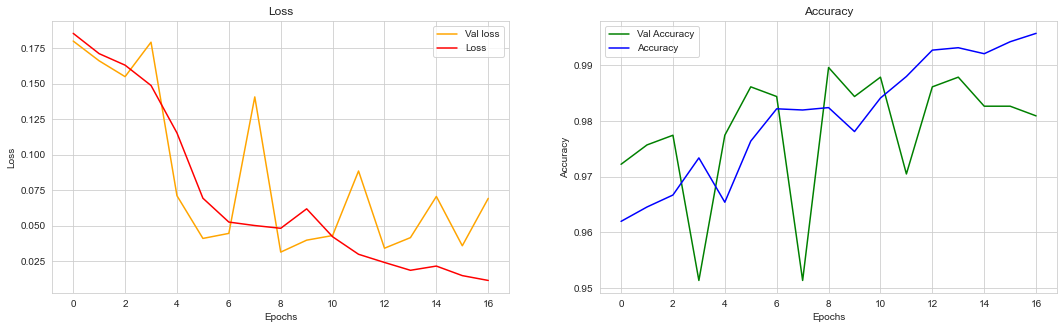

In [91]:
visualize_results(history3)

#### TensorBoard

In [136]:
%tensorboard --logdir logs/

In [ ]:
# This can be copied into command line, and returns url 

# tensorboard dev upload \
#   --logdir logs/ \
#   --name 'Baseline CNN' \
#   --one_shot

Training Data Loss: 0.01724633015692234
Training Data Accuracy 0.9926975965499878
--------------------------
Validation Data Loss: 0.06918268650770187
Validation Data Accuracy 0.9809027910232544 

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       158
         1.0       0.99      0.98      0.99       418

    accuracy                           0.98       576
   macro avg       0.97      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



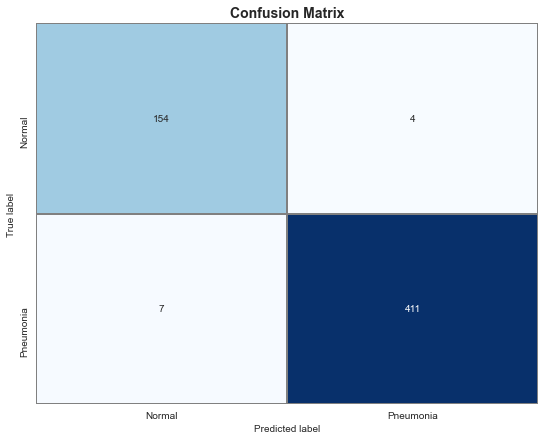

In [118]:
get_results(train_images, train_y, val_images, val_y, cnn_base, 'CNN', total_time)

This model performed well, and it's a good thing we had early stopping. We ended up not having to run through all 50 epochs.

### CNN with Augmentation

Here we will see if we can reduce any overfitting by creating more data using our existing data. We will perform data augmentation to add slightly modified copies and see if it helps our model perform better.

In [77]:
# data augmentation 
train_datagen = ImageDataGenerator(rotation_range= 20, 
                                   width_shift_range= 0.1, 
                                   height_shift_range= 0.1, 
                                   shear_range= 0.2,
                                   horizontal_flip= False, 
                                   vertical_flip= False
                                   zoom_range= 0.2)

In [80]:
#build layers for the model
cnn_aug = Sequential()

cnn_aug.add(layers.Conv2D(32, (3, 3), activation= 'relu', 
                          input_shape= (150, 150, 3)))
cnn_aug.add(layers.MaxPooling2D(2, 2))

cnn_aug.add(layers.Conv2D(32, (4, 4), activation= 'relu'))
cnn_aug.add(layers.MaxPooling2D(2, 2))

cnn_aug.add(layers.Conv2D(64, (3, 3), activation= 'relu'))
cnn_aug.add(layers.MaxPooling2D(2, 2))

cnn_aug.add(layers.Flatten())
cnn_aug.add(layers.Dense(64, activation= 'relu'))
cnn_aug.add(layers.Dense(1, activation= 'sigmoid'))

In [96]:
#make new filepath for the callback
chckpt_filepath = './models/cnn_aug/cnn_aug.{epoch:02d}-{val_loss:.2f}.h5'
model_callbacks = [EarlyStopping(monitor= 'val_loss', 
                                 patience= 5, 
                                 restore_best_weights= True), 
                   ModelCheckpoint(filepath= chckpt_filepath, 
                                   monitor= 'val_loss', 
                                   save_best_only= True)]

#compile and fit new model
cnn_aug.compile(optimizer= 'Adam', 
                loss= 'binary_crossentropy', 
                metrics= ['acc'])

start = datetime.datetime.now()
history4 = cnn_aug.fit(train_datagen.flow(train_images, train_y), 
                       epochs= 50,
                       validation_data= (val_images, val_y), 
                       callbacks = model_callbacks)

end = datetime.datetime.now()
total_time = end-start

Epoch 1/50
146/146 [==============================] - 48s 328ms/step - loss: 0.1680 - acc: 0.9362 - val_loss: 0.1424 - val_acc: 0.9514
Epoch 2/50
146/146 [==============================] - 50s 341ms/step - loss: 0.1705 - acc: 0.9345 - val_loss: 0.1785 - val_acc: 0.9323
Epoch 3/50
146/146 [==============================] - 52s 357ms/step - loss: 0.1587 - acc: 0.9409 - val_loss: 0.1464 - val_acc: 0.9497
Epoch 4/50
146/146 [==============================] - 49s 338ms/step - loss: 0.1505 - acc: 0.9424 - val_loss: 0.1819 - val_acc: 0.9288
Epoch 5/50
146/146 [==============================] - 49s 333ms/step - loss: 0.1539 - acc: 0.9418 - val_loss: 0.2006 - val_acc: 0.9149
Epoch 6/50
146/146 [==============================] - 48s 327ms/step - loss: 0.1543 - acc: 0.9412 - val_loss: 0.1305 - val_acc: 0.9531
Epoch 7/50
146/146 [==============================] - 48s 329ms/step - loss: 0.1545 - acc: 0.9450 - val_loss: 0.1369 - val_acc: 0.9462
Epoch 8/50
146/146 [==============================] - 4

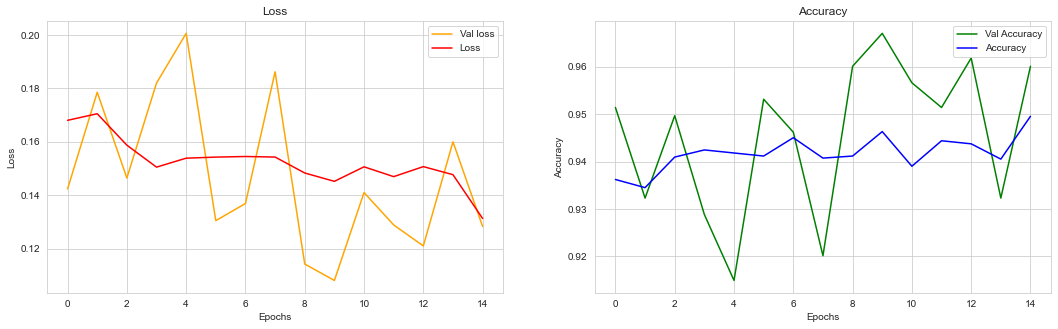

In [97]:
visualize_results(history4)

Training Data Loss: 0.10345534235239029
Training Data Accuracy 0.9671391844749451
--------------------------
Validation Data Loss: 0.10811147093772888
Validation Data Accuracy 0.9670138955116272 

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       158
         1.0       0.98      0.98      0.98       418

    accuracy                           0.97       576
   macro avg       0.96      0.96      0.96       576
weighted avg       0.97      0.97      0.97       576



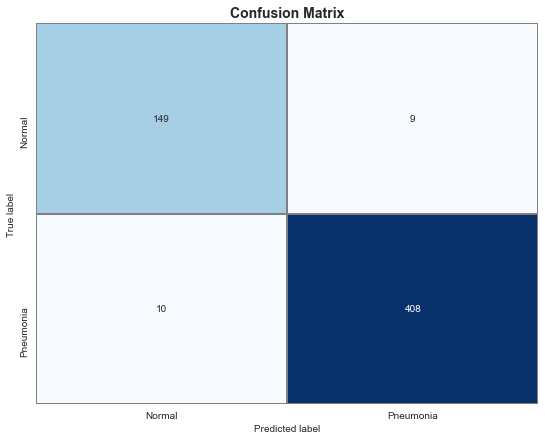

In [119]:
get_results(train_images, train_y, val_images, val_y, cnn_aug, 'CNN_Augmented', 
            total_time)

### CNN with Dropout and Class Weights

In [111]:
# build layers of CNN with Dropout to reduce overfitting
cnn_dropout = Sequential()

cnn_dropout.add(layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=(150, 150, 3)))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))

cnn_dropout.add(layers.Conv2D(64, (4, 4), activation='relu'))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))
cnn_dropout.add(layers.Dropout(0.2))

cnn_dropout.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))
cnn_dropout.add(layers.Dropout(0.2))

cnn_dropout.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))

cnn_dropout.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))
cnn_dropout.add(layers.Dropout(0.2))

cnn_dropout.add(layers.Flatten())
cnn_dropout.add(layers.Dense(128, activation='relu'))
cnn_dropout.add(layers.Dense(1, activation='sigmoid'))

In [112]:
cnn_dropout.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 71, 71, 64)        32832     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 33, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 64)      

In [114]:
#make new filepath for the callback
chckpt_filepath = './models/cnn_dropout/cnncnn_dropout.{epoch:02d}-{val_loss:.2f}.h5'
model_callbacks = [EarlyStopping(monitor= 'val_loss', 
                                 patience= 5, 
                                 restore_best_weights= True), 
                   ModelCheckpoint(filepath= chckpt_filepath, 
                                   monitor= 'val_loss', 
                                   save_best_only= True)]

# compile and fit data
cnn_dropout.compile(optimizer= 'Adam', 
                    loss= 'binary_crossentropy', 
                    metrics= ['acc'])

# adjust class_weights parameter to account for class imbalance
start = datetime.datetime.now()
history5 = cnn_dropout.fit(train_images, train_y, batch_size= 30, epochs= 40, 
                           validation_data= (val_images, val_y),
                           callbacks= model_callbacks, 
                           class_weight= {0:4, 1:0.25})

end = datetime.datetime.now()
total_time = end-start

Epoch 1/40
156/156 [==============================] - 65s 419ms/step - loss: 0.1458 - acc: 0.8737 - val_loss: 0.2679 - val_acc: 0.8889
Epoch 2/40
156/156 [==============================] - 65s 416ms/step - loss: 0.1102 - acc: 0.9018 - val_loss: 0.3984 - val_acc: 0.8628
Epoch 3/40
156/156 [==============================] - 65s 420ms/step - loss: 0.0951 - acc: 0.9107 - val_loss: 0.4188 - val_acc: 0.8316
Epoch 4/40
156/156 [==============================] - 65s 419ms/step - loss: 0.0899 - acc: 0.9119 - val_loss: 0.1868 - val_acc: 0.9167
Epoch 5/40
156/156 [==============================] - 66s 420ms/step - loss: 0.0606 - acc: 0.9422 - val_loss: 0.1520 - val_acc: 0.9392
Epoch 6/40
156/156 [==============================] - 67s 427ms/step - loss: 0.0949 - acc: 0.9152 - val_loss: 0.1886 - val_acc: 0.9219
Epoch 7/40
156/156 [==============================] - 69s 441ms/step - loss: 0.0914 - acc: 0.9207 - val_loss: 0.2496 - val_acc: 0.8976
Epoch 8/40
156/156 [==============================] - 6

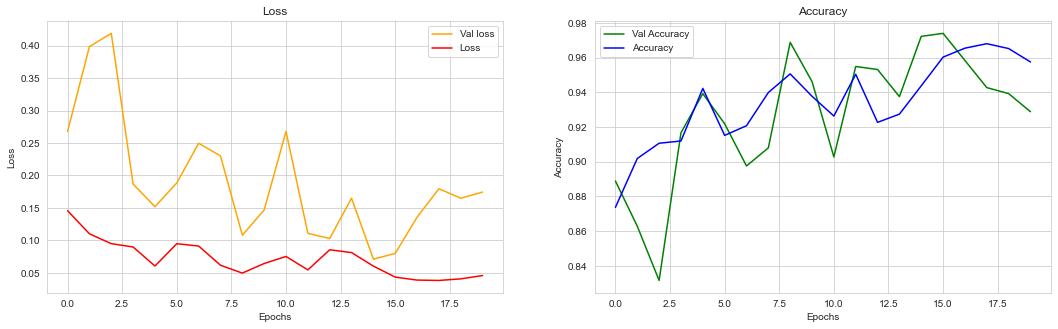

In [115]:
visualize_results(history5)

Training Data Loss: 0.059522006660699844
Training Data Accuracy 0.980240523815155
--------------------------
Validation Data Loss: 0.07119008898735046
Validation Data Accuracy 0.9722222089767456 

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       158
         1.0       0.99      0.98      0.98       418

    accuracy                           0.97       576
   macro avg       0.96      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576



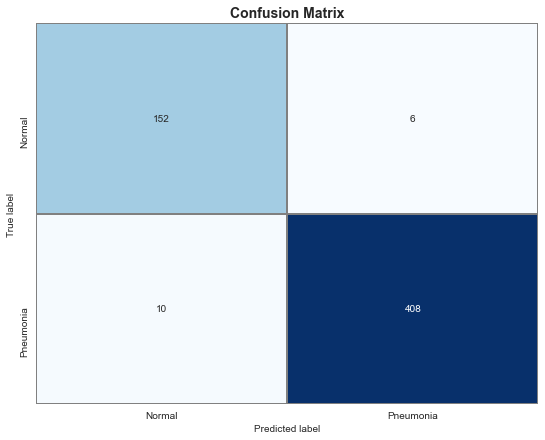

In [116]:
get_results(train_images, train_y, val_images, val_y, cnn_dropout, 
            'CNN Dropout', total_time)

### L2 Regularization

In [125]:
L2_model = Sequential()

L2_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=(150, 150, 3)))
L2_model.add(layers.MaxPooling2D((2, 2)))

L2_model.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_regularizer = regularizers.l2(0.005)))
L2_model.add(layers.MaxPooling2D((2, 2)))

L2_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = regularizers.l2(0.005)))
L2_model.add(layers.MaxPooling2D((2, 2)))

L2_model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer = regularizers.l2(0.005)))
L2_model.add(layers.MaxPooling2D((2, 2)))

L2_model.add(layers.Flatten())
L2_model.add(layers.Dense(128, activation='relu'))
L2_model.add(layers.Dense(1, activation='sigmoid'))

In [126]:
L2_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 71, 71, 64)        32832     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 33, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 14, 14, 128)     

In [129]:
# use callbacks to reduce run times
chckpt_filepath = './models/L2/L2.{epoch:02d}-{val_loss:.2f}.h5'

model_callbacks = [EarlyStopping(monitor= 'val_loss', 
                                 patience= 5, 
                                 restore_best_weights= True), 
                   ModelCheckpoint(filepath= chckpt_filepath, 
                                   monitor= 'val_loss', 
                                   save_best_only= True)]

L2_model.compile(optimizer= 'Adam', loss= 'binary_crossentropy', metrics= ['acc'])

start = datetime.datetime.now()
history6 = L2_model.fit(train_images, train_y, epochs= 50, batch_size= 50, 
                  callbacks= model_callbacks, 
                  validation_data= (val_images, val_y))

end = datetime.datetime.now()
total_time = end-start

Epoch 1/50
94/94 [==============================] - 61s 652ms/step - loss: 0.6494 - acc: 0.8565 - val_loss: 0.3614 - val_acc: 0.9115
Epoch 2/50
94/94 [==============================] - 63s 668ms/step - loss: 0.2858 - acc: 0.9354 - val_loss: 0.5759 - val_acc: 0.8472
Epoch 3/50
94/94 [==============================] - 66s 704ms/step - loss: 0.2297 - acc: 0.9457 - val_loss: 0.2280 - val_acc: 0.9410
Epoch 4/50
94/94 [==============================] - 64s 676ms/step - loss: 0.1790 - acc: 0.9568 - val_loss: 0.2431 - val_acc: 0.9358
Epoch 5/50
94/94 [==============================] - 64s 677ms/step - loss: 0.1814 - acc: 0.9527 - val_loss: 0.3083 - val_acc: 0.8993
Epoch 6/50
94/94 [==============================] - 61s 646ms/step - loss: 0.1620 - acc: 0.9590 - val_loss: 0.1475 - val_acc: 0.9583
Epoch 7/50
94/94 [==============================] - 62s 663ms/step - loss: 0.1373 - acc: 0.9656 - val_loss: 0.1418 - val_acc: 0.9670
Epoch 8/50
94/94 [==============================] - 61s 652ms/step - 

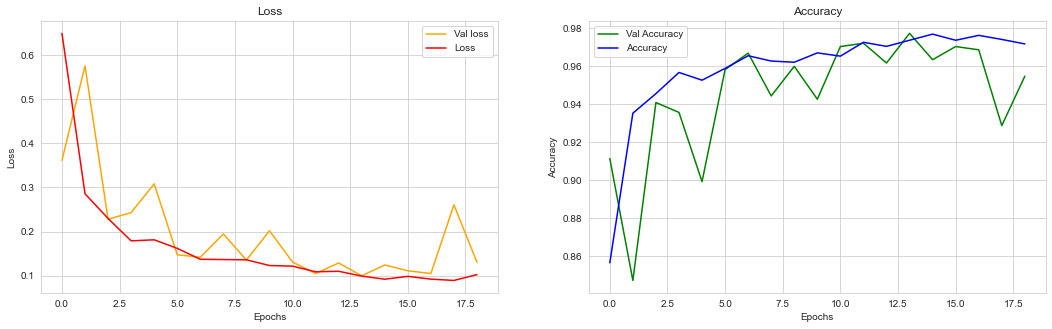

In [130]:
visualize_results(history6)

Training Data Loss: 0.0919007658958435
Training Data Accuracy 0.9772336483001709
--------------------------
Validation Data Loss: 0.09977837651968002
Validation Data Accuracy 0.9774305820465088 

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       158
         1.0       0.98      0.99      0.98       418

    accuracy                           0.98       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.98      0.98      0.98       576



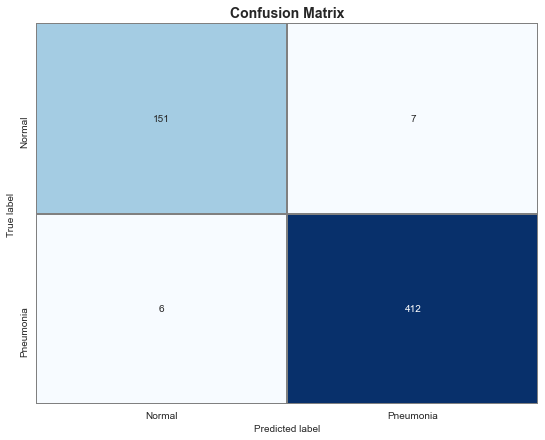

In [131]:
get_results(train_images, train_y, val_images, val_y, L2_model, 'L2', total_time)

### Transfer Learning

## Results:

In [132]:
results_df = pd.DataFrame(results_list, 
                          columns = ['Model', 'Train Loss', 'Val Loss',
                                     'Train Accuracy', 'Val Accuracy', 
                                     'Run Time'])
results_df

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,Run Time
0,baseline,7.12,11.08,97.19,96.70,0 days 00:12:19.269575
1,CNN Dropout,5.95,7.12,98.02,97.22,0 days 00:22:25.057046
2,CNN,1.72,6.92,99.27,98.09,0 days 00:22:25.057046
3,CNN_Augmented,10.35,10.81,96.71,96.70,0 days 00:22:25.057046
4,L2,9.19,9.98,97.72,97.74,0 days 00:20:05.008883


In [ ]:
# fix timedelta
# minutes = divmod(total_time.seconds, 60)  
# print('Total difference in minutes: ', minutes[0], 'minutes', 
#                                  minutes[1], 'seconds') 


# minutes1 = (total_time.seconds//60)%60
# print(minutes1)

In [146]:
results_test = cnn_base.evaluate(test_images, test_y, batch_size= 4)

156/156 [==============================] - 1s 9ms/step - loss: 2.0394 - acc: 0.7788


In [140]:
results_test2 = L2_model.evaluate(test_images, test_y)

20/20 [==============================] - 2s 86ms/step - loss: 0.8991 - acc: 0.7660


In [145]:
results_test3 = cnn_aug.evaluate(test_images, test_y, batch_size= 10)

63/63 [==============================] - 1s 20ms/step - loss: 0.4353 - acc: 0.8558


In [144]:
results_test4 = cnn_dropout.evaluate(test_images, test_y, batch_size= 15)

42/42 [==============================] - 2s 37ms/step - loss: 0.9673 - acc: 0.8045
